In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from sklearn.preprocessing import normalize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

2022-03-07 23:59:20.873005: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-07 23:59:20.873028: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Hyperparameters

NOISE = 0.2        # amount of noise to add to exercise
NETWORK = 'ANN'    # or ANN
THRESHOLD = 1      # 1: mean, 2: max, 3: deterministic
threshold_d = 0.05 # threshold for deterministic

In [3]:
def label_marker(row):
    if isinstance(row['marker'], str) and 'Natural' in row['marker']:
        return 0
    if isinstance(row['marker'], str) and 'Attack' in row['marker']:
        return 1
    return 

In [4]:
path = './data/Zero_Day/'
path_normal = path +'Normal.csv'
path_combine = path +'Combine.csv'
path_attack = path +'Attack.csv'

traffic_df = pd.read_csv(path_normal)  
combine_df = pd.read_csv(path_combine)  
attack_df = pd.read_csv(path_attack)  

combine_df['marker'] = combine_df.apply(label_marker, axis=1)
combine_labels = combine_df['marker'].to_numpy() 
len(combine_labels)

78377

In [5]:
# Delete marker column 
#traffic_df.drop(['marker'], axis=1, inplace=True)
#combine_df.drop(['marker'], axis=1, inplace=True)
#attack_df.drop(['marker'], axis=1, inplace=True)

In [6]:
# each row of the dataframe is considered a sequence
# we create a numpy array with the sequences
traffic_np = traffic_df.to_numpy()
print('normal shape',traffic_np.shape)
combine_np = combine_df.to_numpy()
print('combine shape', combine_np.shape)
attack_np = attack_df.to_numpy()
print('attack shape', attack_np.shape)

normal shape (22714, 129)
combine shape (78377, 129)
attack shape (55663, 129)


In [7]:
combine_df = combine_df.replace([np.inf, -np.inf], 0)
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(combine_df)

In [8]:
df_scaled.shape

(78377, 129)

In [9]:
labels = combine_labels
norm_samples = df_scaled[labels == 1]  # normal data
attack_samples = df_scaled[labels == 0]  # attack data

norm_labels = labels[labels == 1]
attack_labels = labels[labels == 0]

In [10]:
attack_samples.shape

(22714, 129)

In [11]:
# generate train set
# training set will consist of the normal ds

len_norm = len(norm_samples)
len_norm_train = int(0.8 * len_norm)
X_train = norm_samples[:len_norm_train]

# generate test set consist of 50% attack and 50% normal

X_test_norm = norm_samples[len_norm_train:]
len_attack_test = len(X_test_norm) # we will use the same number
X_test_attack = attack_samples[:len_attack_test]

X_test = np.concatenate([X_test_norm, X_test_attack])
y_test = np.ones(len(X_test))
y_test[:len(X_test_norm)] = 0

In [12]:
X_train.shape

(44530, 129)

In [13]:
X_test.shape

(22266, 129)

In [14]:
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [15]:
# The reparameterization trick

def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [16]:
original_dim = X_train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)
intermediate_dim = 512
latent_dim = 256

In [17]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x      = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
z        = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder  = Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 129)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 512)          66560       ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 256)          131328      ['dense[0][0]']                  
                                                                                                  
 z_log_var (Dense)              (None, 256)          131328      ['dense[0][0]']                  
                                                                                            

In [18]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x             = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs       = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder       = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 256)]             0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dense_2 (Dense)             (None, 129)               66177     
                                                                 
Total params: 197,761
Trainable params: 197,761
Non-trainable params: 0
_________________________________________________________________


In [19]:
# full VAE model
outputs   = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name='vae_mlp')

In [20]:
# the KL loss function:
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all 
    total_loss = K.mean(reconstruction_loss + kl_loss)    
    #total_loss = reconstruction_loss + kl_loss
    return total_loss

In [21]:
opt = optimizers.Adam(learning_rate=0.0001, clipvalue=0.5)
#opt = optimizers.RMSprop(learning_rate=0.0001)

vae_model.compile(optimizer=opt, loss=vae_loss)
vae_model.summary()
# Finally, we train the model:
results = vae_model.fit(X_train, X_train,
                        shuffle=True,
                        epochs=1000,
                        callbacks=[
                        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")],
                        batch_size=256)

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 129)]             0         
                                                                 
 encoder (Functional)        (None, 256)               329216    
                                                                 
 decoder (Functional)        (None, 129)               197761    
                                                                 
Total params: 526,977
Trainable params: 526,977
Non-trainable params: 0
_________________________________________________________________
Train on 44530 samples
Epoch 1/600
  256/44530 [..............................] - ETA: 38s - loss: 5391.1494

2022-03-07 23:59:26.555534: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-07 23:59:26.556218: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-07 23:59:26.556300: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-07 23:59:26.556374: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-07 23:59:26.558569: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

44530/44530 [==============================] - 2s 45us/sample - loss: 1507.1166
Epoch 2/600
44530/44530 [==============================] - 2s 40us/sample - loss: 440.4895
Epoch 3/600
44530/44530 [==============================] - 2s 40us/sample - loss: 289.0043
Epoch 4/600
44530/44530 [==============================] - 2s 40us/sample - loss: 227.7838
Epoch 5/600
44530/44530 [==============================] - 2s 42us/sample - loss: 197.4233
Epoch 6/600
44530/44530 [==============================] - 2s 41us/sample - loss: 176.6629
Epoch 7/600
44530/44530 [==============================] - 2s 41us/sample - loss: 161.0685
Epoch 8/600
44530/44530 [==============================] - 2s 41us/sample - loss: 148.0587
Epoch 9/600
44530/44530 [==============================] - 2s 41us/sample - loss: 137.6717
Epoch 10/600
44530/44530 [==============================] - 2s 40us/sample - loss: 129.0765
Epoch 11/600
44530/44530 [==============================] - 2s 41us/sample - loss: 121.9975
Epoch 12

44530/44530 [==============================] - 2s 38us/sample - loss: 30.1297
Epoch 92/600
44530/44530 [==============================] - 2s 38us/sample - loss: 29.8862
Epoch 93/600
44530/44530 [==============================] - 2s 38us/sample - loss: 29.5725
Epoch 94/600
44530/44530 [==============================] - 2s 38us/sample - loss: 29.3284
Epoch 95/600
44530/44530 [==============================] - 2s 38us/sample - loss: 29.0778
Epoch 96/600
44530/44530 [==============================] - 2s 39us/sample - loss: 28.8628
Epoch 97/600
44530/44530 [==============================] - 2s 38us/sample - loss: 28.6380
Epoch 98/600
44530/44530 [==============================] - 2s 38us/sample - loss: 28.4925
Epoch 99/600
44530/44530 [==============================] - 2s 39us/sample - loss: 28.0819
Epoch 100/600
44530/44530 [==============================] - 2s 39us/sample - loss: 27.8988
Epoch 101/600
44530/44530 [==============================] - 2s 39us/sample - loss: 27.8008
Epoch 102/

44530/44530 [==============================] - 2s 41us/sample - loss: 18.1510
Epoch 181/600
44530/44530 [==============================] - 2s 40us/sample - loss: 18.0596
Epoch 182/600
44530/44530 [==============================] - 2s 40us/sample - loss: 18.0377
Epoch 183/600
44530/44530 [==============================] - 2s 40us/sample - loss: 18.0062
Epoch 184/600
44530/44530 [==============================] - 2s 40us/sample - loss: 17.9618
Epoch 185/600
44530/44530 [==============================] - 2s 40us/sample - loss: 17.8307
Epoch 186/600
44530/44530 [==============================] - 2s 40us/sample - loss: 17.8044
Epoch 187/600
44530/44530 [==============================] - 2s 40us/sample - loss: 17.7091
Epoch 188/600
44530/44530 [==============================] - 2s 40us/sample - loss: 17.6269
Epoch 189/600
44530/44530 [==============================] - 2s 40us/sample - loss: 17.6331
Epoch 190/600
44530/44530 [==============================] - 2s 40us/sample - loss: 17.4812
Ep

44530/44530 [==============================] - 2s 41us/sample - loss: 14.0444
Epoch 270/600
44530/44530 [==============================] - 2s 46us/sample - loss: 14.0428
Epoch 271/600
44530/44530 [==============================] - 2s 46us/sample - loss: 14.0198
Epoch 272/600
44530/44530 [==============================] - 2s 46us/sample - loss: 14.0585
Epoch 273/600
44530/44530 [==============================] - 2s 44us/sample - loss: 13.9701
Epoch 274/600
44530/44530 [==============================] - 2s 43us/sample - loss: 13.8764
Epoch 275/600
44530/44530 [==============================] - 2s 43us/sample - loss: 13.9002
Epoch 276/600
44530/44530 [==============================] - 2s 43us/sample - loss: 13.8688
Epoch 277/600
44530/44530 [==============================] - 2s 43us/sample - loss: 13.8287
Epoch 278/600
44530/44530 [==============================] - 2s 43us/sample - loss: 13.7767
Epoch 279/600
44530/44530 [==============================] - 2s 43us/sample - loss: 13.7703
Ep

44530/44530 [==============================] - 2s 42us/sample - loss: 11.9223
Epoch 359/600
44530/44530 [==============================] - 2s 42us/sample - loss: 11.8884
Epoch 360/600
44530/44530 [==============================] - 2s 42us/sample - loss: 11.9318
Epoch 361/600
44530/44530 [==============================] - 2s 42us/sample - loss: 11.9276
Epoch 362/600
44530/44530 [==============================] - 2s 41us/sample - loss: 11.8138
Epoch 363/600
44530/44530 [==============================] - 2s 42us/sample - loss: 11.8505
Epoch 364/600
44530/44530 [==============================] - 2s 42us/sample - loss: 11.8323
Epoch 365/600
44530/44530 [==============================] - 2s 42us/sample - loss: 11.8299
Epoch 366/600
44530/44530 [==============================] - 2s 42us/sample - loss: 11.7701
Epoch 367/600
44530/44530 [==============================] - 2s 42us/sample - loss: 11.6925
Epoch 368/600
44530/44530 [==============================] - 2s 44us/sample - loss: 11.7617
Ep

44530/44530 [==============================] - 2s 42us/sample - loss: 10.4136
Epoch 448/600
44530/44530 [==============================] - 2s 52us/sample - loss: 10.3859
Epoch 449/600
44530/44530 [==============================] - 2s 47us/sample - loss: 10.3521
Epoch 450/600
44530/44530 [==============================] - 2s 46us/sample - loss: 10.4450
Epoch 451/600
44530/44530 [==============================] - 2s 47us/sample - loss: 10.4029
Epoch 452/600
44530/44530 [==============================] - 2s 45us/sample - loss: 10.3493
Epoch 453/600
44530/44530 [==============================] - 2s 44us/sample - loss: 10.3360
Epoch 454/600
44530/44530 [==============================] - 2s 44us/sample - loss: 10.3449
Epoch 455/600
44530/44530 [==============================] - 2s 47us/sample - loss: 10.2930
Epoch 456/600
44530/44530 [==============================] - 2s 56us/sample - loss: 10.2311
Epoch 457/600
44530/44530 [==============================] - 3s 57us/sample - loss: 10.2415
Ep

44530/44530 [==============================] - 2s 56us/sample - loss: 9.4672
Epoch 537/600
44530/44530 [==============================] - 2s 51us/sample - loss: 9.4428
Epoch 538/600
44530/44530 [==============================] - 3s 64us/sample - loss: 9.4793
Epoch 539/600
44530/44530 [==============================] - 3s 75us/sample - loss: 9.5361
Epoch 540/600
44530/44530 [==============================] - 4s 87us/sample - loss: 9.4512
Epoch 541/600
44530/44530 [==============================] - 3s 61us/sample - loss: 9.4206
Epoch 542/600
44530/44530 [==============================] - 3s 61us/sample - loss: 9.4044
Epoch 543/600
44530/44530 [==============================] - 3s 61us/sample - loss: 9.5060
Epoch 544/600
44530/44530 [==============================] - 3s 64us/sample - loss: 9.4517
Epoch 545/600
44530/44530 [==============================] - 3s 72us/sample - loss: 9.4107
Epoch 546/600
44530/44530 [==============================] - 3s 75us/sample - loss: 9.3422
Epoch 547/600

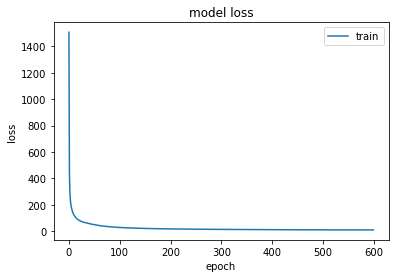

In [22]:
plt.plot(results.history['loss'])
#plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

KeyError: 'val_loss'

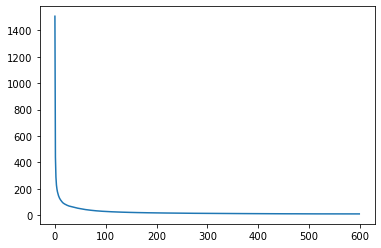

In [35]:
plt.plot(results.history["loss"], label="Training Loss")
plt.plot(results.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [23]:
X_train_pred = vae_model.predict(X_train)

/home/manero/anaconda3/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [38]:
mae_vector = get_error_term(X_train_pred, X_train, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

error_thresh = np.quantile(mae_vector, 0.99)
error_thresh = np.quantile(mae_vector, 0.95)
print(error_thresh)

Avg error 0.007940593751862433
median error 0.006670659309958214
99Q: 0.025994039555927384
setting threshold on 0.025994039555927384 
0.017291023279226218


In [39]:
X_pred = vae_model.predict(X_test)
mae_vector = get_error_term(X_pred, X_test, _rmse=False)
anomalies = (mae_vector > error_thresh)

np.count_nonzero(anomalies) / len(anomalies)

0.5282942603071948

In [40]:
from sklearn.metrics import classification_report

print(classification_report(y_test, anomalies))

              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97     11133
         1.0       0.95      1.00      0.97     11133

    accuracy                           0.97     22266
   macro avg       0.97      0.97      0.97     22266
weighted avg       0.97      0.97      0.97     22266



In [41]:
X_pred.shape

(22266, 129)

In [42]:
X_encoded = encoder.predict(X_test)

In [43]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_transform = pca.fit_transform(X_encoded)

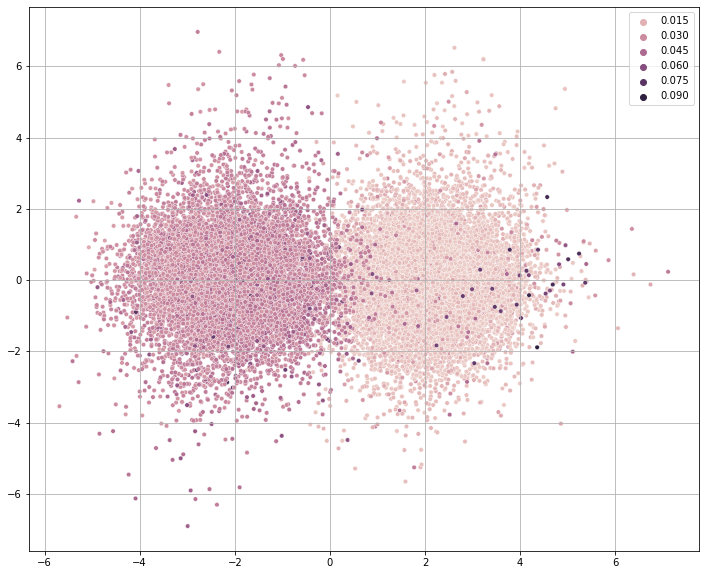

In [44]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector)
plt.grid()
plt.show()

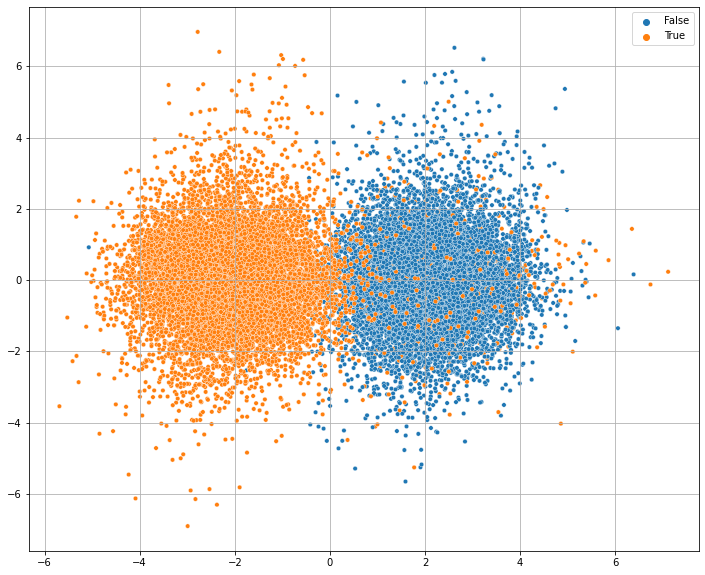

In [45]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=anomalies)
plt.grid()
plt.show()

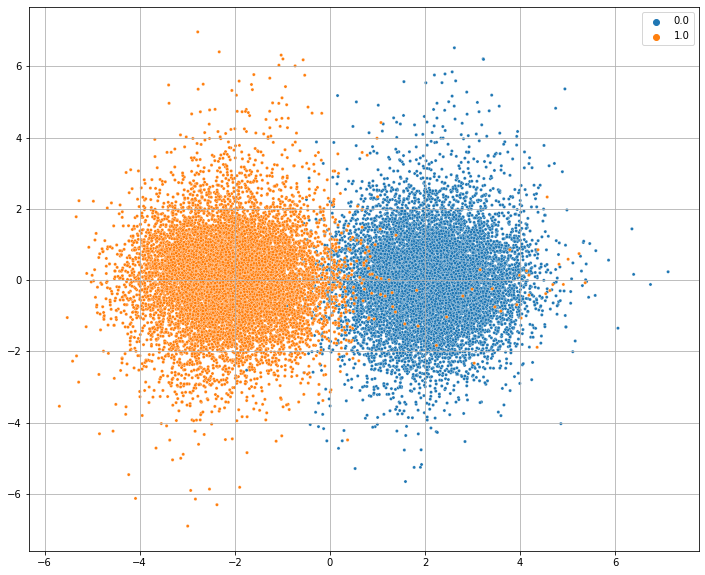

In [46]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=y_test)
plt.grid()
plt.show()

In [47]:
X_pred.shape

(22266, 129)

0.017291023279226218


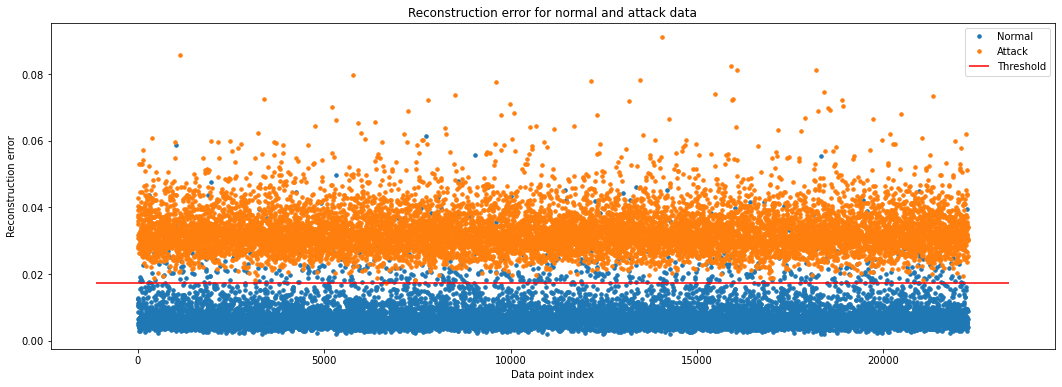

In [48]:
# figure
error_df = pd.DataFrame({'Reconstruction_error': np.squeeze(mae_vector),
                        'True_class': y_test})

error_df = error_df.sample(frac=1).reset_index(drop=True)
threshold_fixed = error_thresh
print(error_thresh)
groups = error_df.groupby('True_class')

fig, ax = plt.subplots(figsize=(18,6))
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Attack" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and attack data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()